In [1]:
#import cupy as cp
from easyesn.optimizers import GradientOptimizer
from easyesn import PredictionESN
from easyesn.optimizers import GridSearchOptimizer
from easyesn import helper as hlp
import numpy as np
from wikipedia2vec import Wikipedia2Vec

np.random.seed(4)
vectorDim = 100

numNode = 100

inputDataTraining = np.load('./trainingData_averaging/inputDataTraining_4k_average.npy')
outputDataTraining = np.load('./trainingData_averaging/outputDataTraining_4k_average.npy')

Using Numpy backend.


In [2]:
print(inputDataTraining.shape)

(1526309, 100)


In [3]:
esn = PredictionESN(n_input=vectorDim, n_output=vectorDim, n_reservoir=numNode, leakingRate=0.2, regressionParameters=[1e-2], solver="lsqr", feedback=False)

In [4]:
esn.fit(inputDataTraining, outputDataTraining, transientTime="Auto", verbose=1)

100% (1526209 of 1526209) |##############| Elapsed Time: 0:00:54 Time:  0:00:54


0.06865680262922515

In [5]:
wiki2vec = Wikipedia2Vec.load('enwiki_20180420_100d.pkl')

discourse_words = ['peanut', 'neutral','woman', 'saw', 'dancing', 'peanut', 'big', 'smile', 'his', 'face', 'peanut', 'singing', 'girl', 'just', 'met', 'judging', 'song', 'peanut', 'totally', 'crazy', 'her', 'woman', 'thought', 'really', 'cute', 'see', 'peanut', 'singing', 'dancing', 'peanut']
#discourse_words = ['peanuts', 'snacks', 'bowl', 'bar', 'people', 'eating', 'chips', 'drinking', 'beer', 'watching', 'football', 'game', 'woman', 'saw', 'dancing', 'peanut', 'big', 'smile', 'his', 'face', 'peanut', 'singing', 'girl', 'just', 'met', 'judging', 'song', 'peanut', 'totally', 'crazy', 'her', 'woman', 'thought', 'really', 'cute', 'see', 'peanut', 'singing', 'dancing', 'peanut']
print(discourse_words)

['peanut', 'neutral', 'woman', 'saw', 'dancing', 'peanut', 'big', 'smile', 'his', 'face', 'peanut', 'singing', 'girl', 'just', 'met', 'judging', 'song', 'peanut', 'totally', 'crazy', 'her', 'woman', 'thought', 'really', 'cute', 'see', 'peanut', 'singing', 'dancing', 'peanut']


In [6]:
inputDataTesting = np.empty((0,vectorDim))
print(inputDataTesting.shape)

for num in range(len(discourse_words)):
    inputDataTesting = np.append(inputDataTesting, np.array([wiki2vec.get_word_vector(discourse_words[num])]), axis=0)
print(inputDataTesting.shape)

(0, 100)
(30, 100)


In [7]:
prediction = esn.predict(inputDataTesting)
#print(prediction)
print(prediction.shape)

(30, 100)


In [8]:
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

consistentOutputDataTesting = np.empty((0,vectorDim))
inconsistentOutputDataTesting = np.empty((0,vectorDim))
print(consistentOutputDataTesting.shape)
print(inconsistentOutputDataTesting.shape)

for num in range(len(discourse_words) - 1):
    consistentOutputDataTesting = np.append(consistentOutputDataTesting, np.array([wiki2vec.get_word_vector(discourse_words[num + 1])]), axis=0)
    inconsistentOutputDataTesting = np.append(inconsistentOutputDataTesting, np.array([wiki2vec.get_word_vector(discourse_words[num + 1])]), axis=0)
consistentOutputDataTesting = np.append(consistentOutputDataTesting, np.array([wiki2vec.get_word_vector('love')]), axis=0)
inconsistentOutputDataTesting = np.append(inconsistentOutputDataTesting, np.array([wiki2vec.get_word_vector('salted')]), axis=0)
print(consistentOutputDataTesting.shape)
print(inconsistentOutputDataTesting.shape)


consistent_trajectory = np.array([])
inconsistent_trajectory = np.array([])

consistent_vector = wiki2vec.get_word_vector('love')
inconsistent_vector = wiki2vec.get_word_vector('salted')

for num in range(len(prediction)):
    consistent_trajectory = np.append(consistent_trajectory, cos_sim(consistent_vector, prediction[num]))
    inconsistent_trajectory = np.append(inconsistent_trajectory, cos_sim(inconsistent_vector, prediction[num]))
    #consistent_trajectory = np.append(consistent_trajectory, cos_sim(consistentOutputDataTesting[num], prediction[num]))
    #inconsistent_trajectory = np.append(inconsistent_trajectory, cos_sim(inconsistentOutputDataTesting[num], prediction[num]))
print(inconsistent_trajectory)
print(consistent_trajectory)

(0, 100)
(0, 100)
(30, 100)
(30, 100)
[0.50764559 0.49805657 0.46688856 0.45513047 0.45953579 0.54624346
 0.51972204 0.51168439 0.47383422 0.43565708 0.52540994 0.49133634
 0.47221193 0.4619047  0.43214198 0.41356638 0.41704579 0.52590735
 0.49159811 0.49520981 0.4717821  0.43190426 0.43963971 0.43082551
 0.42308611 0.39825064 0.49557229 0.45840402 0.45291994 0.53932471]
[0.43281191 0.42415153 0.47626039 0.46506755 0.51652924 0.50110126
 0.52118615 0.57801792 0.57605373 0.57894685 0.56105673 0.60623785
 0.64274238 0.63930112 0.64077067 0.61586287 0.65240632 0.62522813
 0.64121494 0.66539354 0.67428144 0.67723843 0.6669224  0.6821902
 0.68902372 0.67417474 0.65286543 0.67789942 0.6862575  0.64956823]


In [9]:
inconsistent_trajectory = 1 - inconsistent_trajectory
consistent_trajectory = 1 - consistent_trajectory

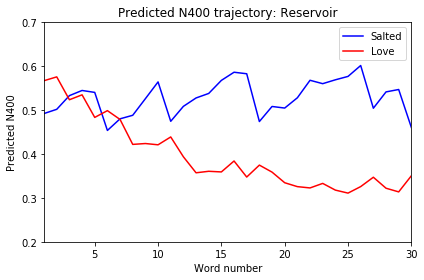

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,4))
t = np.linspace(1, len(discourse_words), len(discourse_words))

ax.set_xlabel('Word number')
ax.set_ylabel('Predicted N400')
ax.set_title(r'Predicted N400 trajectory: Reservoir')
ax.set_xlim([1,len(discourse_words)])
ax.set_ylim([0.2, 0.7])

ax.plot(t, inconsistent_trajectory, color="blue", label="Salted")
ax.plot(t, consistent_trajectory, color="red", label="Love")

ax.legend(loc=0)
fig.tight_layout()
plt.savefig('test_averaging_reservoir-N400-R1.png', dpi=1200)
plt.show()